# Two-qubit States Reconstruction

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [6]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [7]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [9]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [10]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity 

In [11]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [12]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [13]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

In [14]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [15]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [16]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [70]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [71]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [72]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [73]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [74]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [75]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [76]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 1s 71ms/step - loss: 0.2042 - val_loss: 0.1947
Epoch 2/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1900 - val_loss: 0.1830
Epoch 3/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1788 - val_loss: 0.1727
Epoch 4/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1682 - val_loss: 0.1628
Epoch 5/600
6/6 [==============================] - 0s 17ms/step - loss: 0.1577 - val_loss: 0.1524
Epoch 6/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1465 - val_loss: 0.1413
Epoch 7/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1348 - val_loss: 0.1298
Epoch 8/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1225 - val_loss: 0.1182
Epoch 9/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1103 - val_loss: 0.1064
Epoch 10/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0982 - val_loss: 0.0952
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 85/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 86/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 87/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 88/600
6/6 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 89/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 90/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 91/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 92/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 93/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 94/6

6/6 [==============================] - 0s 21ms/step - loss: 5.3119e-04 - val_loss: 0.0014
Epoch 164/600
6/6 [==============================] - 0s 21ms/step - loss: 5.2937e-04 - val_loss: 0.0015
Epoch 165/600
6/6 [==============================] - 0s 20ms/step - loss: 5.2433e-04 - val_loss: 0.0014
Epoch 166/600
6/6 [==============================] - 0s 21ms/step - loss: 5.2154e-04 - val_loss: 0.0014
Epoch 167/600
6/6 [==============================] - 0s 21ms/step - loss: 5.1130e-04 - val_loss: 0.0014
Epoch 168/600
6/6 [==============================] - 0s 19ms/step - loss: 5.0811e-04 - val_loss: 0.0014
Epoch 169/600
6/6 [==============================] - 0s 21ms/step - loss: 5.2107e-04 - val_loss: 0.0014
Epoch 170/600
6/6 [==============================] - 0s 21ms/step - loss: 5.1460e-04 - val_loss: 0.0014
Epoch 171/600
6/6 [==============================] - 0s 21ms/step - loss: 5.0449e-04 - val_loss: 0.0014
Epoch 172/600
6/6 [==============================] - 0s 21ms/step - loss: 5.06

Epoch 242/600
6/6 [==============================] - 0s 21ms/step - loss: 3.4655e-04 - val_loss: 0.0011
Epoch 243/600
6/6 [==============================] - 0s 21ms/step - loss: 3.3279e-04 - val_loss: 0.0011
Epoch 244/600
6/6 [==============================] - 0s 18ms/step - loss: 3.2942e-04 - val_loss: 0.0011
Epoch 245/600
6/6 [==============================] - 0s 18ms/step - loss: 3.2007e-04 - val_loss: 0.0011
Epoch 246/600
6/6 [==============================] - 0s 21ms/step - loss: 3.2374e-04 - val_loss: 0.0011
Epoch 247/600
6/6 [==============================] - 0s 19ms/step - loss: 3.2803e-04 - val_loss: 0.0011
Epoch 248/600
6/6 [==============================] - 0s 21ms/step - loss: 3.4384e-04 - val_loss: 0.0011
Epoch 249/600
6/6 [==============================] - 0s 17ms/step - loss: 3.4027e-04 - val_loss: 0.0011
Epoch 250/600
6/6 [==============================] - 0s 17ms/step - loss: 3.3728e-04 - val_loss: 0.0011
Epoch 251/600
6/6 [==============================] - 0s 21ms/ste

6/6 [==============================] - 0s 16ms/step - loss: 2.3872e-04 - val_loss: 8.7645e-04
Epoch 320/600
6/6 [==============================] - 0s 18ms/step - loss: 2.3170e-04 - val_loss: 8.8007e-04
Epoch 321/600
6/6 [==============================] - 0s 18ms/step - loss: 2.3586e-04 - val_loss: 8.4458e-04
Epoch 322/600
6/6 [==============================] - 0s 16ms/step - loss: 2.3100e-04 - val_loss: 8.4972e-04
Epoch 323/600
6/6 [==============================] - 0s 16ms/step - loss: 2.2250e-04 - val_loss: 8.3928e-04
Epoch 324/600
6/6 [==============================] - 0s 18ms/step - loss: 2.2007e-04 - val_loss: 8.4873e-04
Epoch 325/600
6/6 [==============================] - 0s 19ms/step - loss: 2.2311e-04 - val_loss: 8.4532e-04
Epoch 326/600
6/6 [==============================] - 0s 22ms/step - loss: 2.2112e-04 - val_loss: 8.3762e-04
Epoch 327/600
6/6 [==============================] - 0s 18ms/step - loss: 2.2345e-04 - val_loss: 8.2997e-04
Epoch 328/600
6/6 [=======================

Epoch 395/600
6/6 [==============================] - 0s 18ms/step - loss: 1.6114e-04 - val_loss: 6.8619e-04
Epoch 396/600
6/6 [==============================] - 0s 17ms/step - loss: 1.6562e-04 - val_loss: 6.9693e-04
Epoch 397/600
6/6 [==============================] - 0s 20ms/step - loss: 1.6435e-04 - val_loss: 6.8553e-04
Epoch 398/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5927e-04 - val_loss: 6.7943e-04
Epoch 399/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5498e-04 - val_loss: 6.6685e-04
Epoch 400/600
6/6 [==============================] - 0s 15ms/step - loss: 1.5457e-04 - val_loss: 6.6422e-04
Epoch 401/600
6/6 [==============================] - 0s 22ms/step - loss: 1.6426e-04 - val_loss: 6.8168e-04
Epoch 402/600
6/6 [==============================] - 0s 21ms/step - loss: 1.5989e-04 - val_loss: 6.9025e-04
Epoch 403/600
6/6 [==============================] - 0s 19ms/step - loss: 1.5922e-04 - val_loss: 6.7968e-04
Epoch 404/600
6/6 [=========

Epoch 471/600
6/6 [==============================] - 0s 16ms/step - loss: 1.1591e-04 - val_loss: 5.7095e-04
Epoch 472/600
6/6 [==============================] - 0s 18ms/step - loss: 1.1505e-04 - val_loss: 5.6594e-04
Epoch 473/600
6/6 [==============================] - 0s 19ms/step - loss: 1.1669e-04 - val_loss: 5.6801e-04
Epoch 474/600
6/6 [==============================] - 0s 21ms/step - loss: 1.2089e-04 - val_loss: 5.6488e-04
Epoch 475/600
6/6 [==============================] - 0s 21ms/step - loss: 1.2180e-04 - val_loss: 5.7239e-04
Epoch 476/600
6/6 [==============================] - 0s 19ms/step - loss: 1.2079e-04 - val_loss: 5.7690e-04
Epoch 477/600
6/6 [==============================] - 0s 19ms/step - loss: 1.2430e-04 - val_loss: 5.5917e-04
Epoch 478/600
6/6 [==============================] - 0s 18ms/step - loss: 1.1514e-04 - val_loss: 5.5173e-04
Epoch 479/600
6/6 [==============================] - 0s 19ms/step - loss: 1.0696e-04 - val_loss: 5.5350e-04
Epoch 480/600
6/6 [=========

Epoch 547/600
6/6 [==============================] - 0s 16ms/step - loss: 8.8155e-05 - val_loss: 4.7768e-04
Epoch 548/600
6/6 [==============================] - 0s 16ms/step - loss: 8.5402e-05 - val_loss: 4.7563e-04
Epoch 549/600
6/6 [==============================] - 0s 18ms/step - loss: 8.3154e-05 - val_loss: 4.8062e-04
Epoch 550/600
6/6 [==============================] - 0s 16ms/step - loss: 8.7180e-05 - val_loss: 4.8826e-04
Epoch 551/600
6/6 [==============================] - 0s 18ms/step - loss: 8.8599e-05 - val_loss: 4.9054e-04
Epoch 552/600
6/6 [==============================] - 0s 21ms/step - loss: 8.9272e-05 - val_loss: 4.9027e-04
Epoch 553/600
6/6 [==============================] - 0s 18ms/step - loss: 9.4070e-05 - val_loss: 4.9305e-04
Epoch 554/600
6/6 [==============================] - 0s 19ms/step - loss: 9.5641e-05 - val_loss: 4.8648e-04
Epoch 555/600
6/6 [==============================] - 0s 19ms/step - loss: 8.6158e-05 - val_loss: 4.8503e-04
Epoch 556/600
6/6 [=========

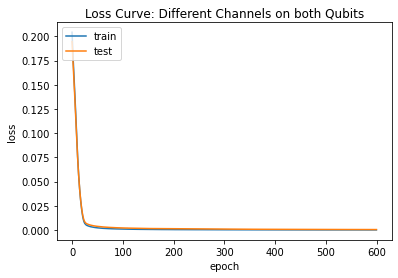

In [77]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 4.3599e-04 - 201ms/epoch - 29ms/step


In [79]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.9935952+5.0931702e-12j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [80]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [81]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [82]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [83]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [84]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [85]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [86]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 1s 68ms/step - loss: 0.2085 - val_loss: 0.1949
Epoch 2/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1913 - val_loss: 0.1833
Epoch 3/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1787 - val_loss: 0.1737
Epoch 4/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1679 - val_loss: 0.1648
Epoch 5/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1577 - val_loss: 0.1556
Epoch 6/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1476 - val_loss: 0.1462
Epoch 7/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1371 - val_loss: 0.1365
Epoch 8/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1265 - val_loss: 0.1265
Epoch 9/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1157 - val_loss: 0.1163
Epoch 10/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1051 - val_loss: 0.1064
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 85/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 86/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 87/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 88/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 89/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 90/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 91/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 92/600
6/6 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 93/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 94/6

6/6 [==============================] - 0s 16ms/step - loss: 5.1733e-04 - val_loss: 0.0014
Epoch 164/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0890e-04 - val_loss: 0.0015
Epoch 165/600
6/6 [==============================] - 0s 18ms/step - loss: 5.1386e-04 - val_loss: 0.0014
Epoch 166/600
6/6 [==============================] - 0s 18ms/step - loss: 5.1431e-04 - val_loss: 0.0014
Epoch 167/600
6/6 [==============================] - 0s 16ms/step - loss: 5.1363e-04 - val_loss: 0.0014
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0687e-04 - val_loss: 0.0014
Epoch 169/600
6/6 [==============================] - 0s 16ms/step - loss: 5.0232e-04 - val_loss: 0.0014
Epoch 170/600
6/6 [==============================] - 0s 16ms/step - loss: 5.0041e-04 - val_loss: 0.0014
Epoch 171/600
6/6 [==============================] - 0s 16ms/step - loss: 4.9199e-04 - val_loss: 0.0014
Epoch 172/600
6/6 [==============================] - 0s 16ms/step - loss: 4.90

Epoch 242/600
6/6 [==============================] - 0s 16ms/step - loss: 3.1736e-04 - val_loss: 0.0010
Epoch 243/600
6/6 [==============================] - 0s 15ms/step - loss: 3.0967e-04 - val_loss: 0.0010
Epoch 244/600
6/6 [==============================] - 0s 19ms/step - loss: 3.1774e-04 - val_loss: 0.0010
Epoch 245/600
6/6 [==============================] - 0s 16ms/step - loss: 3.1404e-04 - val_loss: 0.0010
Epoch 246/600
6/6 [==============================] - 0s 18ms/step - loss: 3.2060e-04 - val_loss: 0.0010
Epoch 247/600
6/6 [==============================] - 0s 15ms/step - loss: 3.0833e-04 - val_loss: 0.0010
Epoch 248/600
6/6 [==============================] - 0s 17ms/step - loss: 3.0910e-04 - val_loss: 9.8964e-04
Epoch 249/600
6/6 [==============================] - 0s 18ms/step - loss: 3.0542e-04 - val_loss: 9.8474e-04
Epoch 250/600
6/6 [==============================] - 0s 16ms/step - loss: 2.9803e-04 - val_loss: 0.0010
Epoch 251/600
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 21ms/step - loss: 2.1790e-04 - val_loss: 7.6642e-04
Epoch 319/600
6/6 [==============================] - 0s 21ms/step - loss: 2.1422e-04 - val_loss: 7.7383e-04
Epoch 320/600
6/6 [==============================] - 0s 19ms/step - loss: 2.1572e-04 - val_loss: 7.8325e-04
Epoch 321/600
6/6 [==============================] - 0s 21ms/step - loss: 2.1811e-04 - val_loss: 7.8281e-04
Epoch 322/600
6/6 [==============================] - 0s 21ms/step - loss: 2.1438e-04 - val_loss: 7.7922e-04
Epoch 323/600
6/6 [==============================] - 0s 21ms/step - loss: 2.0431e-04 - val_loss: 7.5702e-04
Epoch 324/600
6/6 [==============================] - 0s 18ms/step - loss: 2.0546e-04 - val_loss: 7.5893e-04
Epoch 325/600
6/6 [==============================] - 0s 17ms/step - loss: 2.0593e-04 - val_loss: 7.5666e-04
Epoch 326/600
6/6 [==============================] - 0s 19ms/step - loss: 2.0752e-04 - val_loss: 7.5369e-04
Epoch 327/600
6/6 [=======================

Epoch 394/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5600e-04 - val_loss: 6.2766e-04
Epoch 395/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5734e-04 - val_loss: 6.4142e-04
Epoch 396/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5416e-04 - val_loss: 6.2510e-04
Epoch 397/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5122e-04 - val_loss: 6.2782e-04
Epoch 398/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5077e-04 - val_loss: 6.2128e-04
Epoch 399/600
6/6 [==============================] - 0s 16ms/step - loss: 1.4996e-04 - val_loss: 6.2636e-04
Epoch 400/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5434e-04 - val_loss: 6.2038e-04
Epoch 401/600
6/6 [==============================] - 0s 17ms/step - loss: 1.4718e-04 - val_loss: 6.1494e-04
Epoch 402/600
6/6 [==============================] - 0s 18ms/step - loss: 1.4832e-04 - val_loss: 6.0542e-04
Epoch 403/600
6/6 [=========

Epoch 470/600
6/6 [==============================] - 0s 16ms/step - loss: 1.2212e-04 - val_loss: 5.4054e-04
Epoch 471/600
6/6 [==============================] - 0s 18ms/step - loss: 1.1890e-04 - val_loss: 5.3822e-04
Epoch 472/600
6/6 [==============================] - 0s 17ms/step - loss: 1.1824e-04 - val_loss: 5.2670e-04
Epoch 473/600
6/6 [==============================] - 0s 18ms/step - loss: 1.2202e-04 - val_loss: 5.2515e-04
Epoch 474/600
6/6 [==============================] - 0s 16ms/step - loss: 1.1570e-04 - val_loss: 5.1635e-04
Epoch 475/600
6/6 [==============================] - 0s 16ms/step - loss: 1.1338e-04 - val_loss: 5.2236e-04
Epoch 476/600
6/6 [==============================] - 0s 16ms/step - loss: 1.1087e-04 - val_loss: 5.1339e-04
Epoch 477/600
6/6 [==============================] - 0s 19ms/step - loss: 1.0689e-04 - val_loss: 5.2402e-04
Epoch 478/600
6/6 [==============================] - 0s 18ms/step - loss: 1.1134e-04 - val_loss: 5.2776e-04
Epoch 479/600
6/6 [=========

Epoch 546/600
6/6 [==============================] - 0s 16ms/step - loss: 9.0501e-05 - val_loss: 4.5207e-04
Epoch 547/600
6/6 [==============================] - 0s 19ms/step - loss: 9.1560e-05 - val_loss: 4.5301e-04
Epoch 548/600
6/6 [==============================] - 0s 21ms/step - loss: 8.6494e-05 - val_loss: 4.4945e-04
Epoch 549/600
6/6 [==============================] - 0s 18ms/step - loss: 8.9063e-05 - val_loss: 4.5151e-04
Epoch 550/600
6/6 [==============================] - 0s 19ms/step - loss: 9.2038e-05 - val_loss: 4.6019e-04
Epoch 551/600
6/6 [==============================] - 0s 21ms/step - loss: 9.3806e-05 - val_loss: 4.4913e-04
Epoch 552/600
6/6 [==============================] - 0s 23ms/step - loss: 8.7409e-05 - val_loss: 4.4765e-04
Epoch 553/600
6/6 [==============================] - 0s 19ms/step - loss: 8.7861e-05 - val_loss: 4.4554e-04
Epoch 554/600
6/6 [==============================] - 0s 18ms/step - loss: 8.6827e-05 - val_loss: 4.4125e-04
Epoch 555/600
6/6 [=========

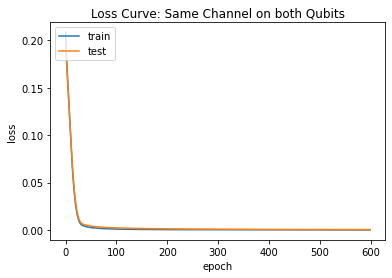

In [87]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 3.5656e-04 - 178ms/epoch - 25ms/step


In [89]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.9953616+1.193257e-11j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [90]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [91]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [92]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [93]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [104]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [105]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [106]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 1s 56ms/step - loss: 0.2080 - val_loss: 0.1966
Epoch 2/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1873 - val_loss: 0.1801
Epoch 3/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1713 - val_loss: 0.1671
Epoch 4/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1575 - val_loss: 0.1547
Epoch 5/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1443 - val_loss: 0.1424
Epoch 6/600
6/6 [==============================] - 0s 23ms/step - loss: 0.1313 - val_loss: 0.1298
Epoch 7/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1183 - val_loss: 0.1170
Epoch 8/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1053 - val_loss: 0.1044
Epoch 9/600
6/6 [==============================] - 0s 14ms/step - loss: 0.0927 - val_loss: 0.0923
Epoch 10/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0808 - val_loss: 0.0807
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 85/600
6/6 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 86/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 87/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 88/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 89/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 90/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 91/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 92/600
6/6 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 93/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 94/6

6/6 [==============================] - 0s 16ms/step - loss: 7.4113e-04 - val_loss: 0.0021
Epoch 165/600
6/6 [==============================] - 0s 18ms/step - loss: 7.3137e-04 - val_loss: 0.0021
Epoch 166/600
6/6 [==============================] - 0s 16ms/step - loss: 7.3224e-04 - val_loss: 0.0021
Epoch 167/600
6/6 [==============================] - 0s 16ms/step - loss: 7.2153e-04 - val_loss: 0.0021
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 7.3023e-04 - val_loss: 0.0021
Epoch 169/600
6/6 [==============================] - 0s 16ms/step - loss: 7.2191e-04 - val_loss: 0.0021
Epoch 170/600
6/6 [==============================] - 0s 16ms/step - loss: 7.1203e-04 - val_loss: 0.0021
Epoch 171/600
6/6 [==============================] - 0s 18ms/step - loss: 7.2563e-04 - val_loss: 0.0021
Epoch 172/600
6/6 [==============================] - 0s 17ms/step - loss: 7.1467e-04 - val_loss: 0.0021
Epoch 173/600
6/6 [==============================] - 0s 18ms/step - loss: 6.94

Epoch 243/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8974e-04 - val_loss: 0.0018
Epoch 244/600
6/6 [==============================] - 0s 16ms/step - loss: 4.9789e-04 - val_loss: 0.0018
Epoch 245/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8975e-04 - val_loss: 0.0018
Epoch 246/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8501e-04 - val_loss: 0.0018
Epoch 247/600
6/6 [==============================] - 0s 18ms/step - loss: 4.7495e-04 - val_loss: 0.0018
Epoch 248/600
6/6 [==============================] - 0s 16ms/step - loss: 4.6923e-04 - val_loss: 0.0018
Epoch 249/600
6/6 [==============================] - 0s 22ms/step - loss: 4.7535e-04 - val_loss: 0.0018
Epoch 250/600
6/6 [==============================] - 0s 21ms/step - loss: 4.6773e-04 - val_loss: 0.0018
Epoch 251/600
6/6 [==============================] - 0s 21ms/step - loss: 4.7315e-04 - val_loss: 0.0018
Epoch 252/600
6/6 [==============================] - 0s 18ms/ste

Epoch 322/600
6/6 [==============================] - 0s 19ms/step - loss: 3.7352e-04 - val_loss: 0.0016
Epoch 323/600
6/6 [==============================] - 0s 18ms/step - loss: 3.7343e-04 - val_loss: 0.0016
Epoch 324/600
6/6 [==============================] - 0s 15ms/step - loss: 3.7017e-04 - val_loss: 0.0016
Epoch 325/600
6/6 [==============================] - 0s 16ms/step - loss: 3.6978e-04 - val_loss: 0.0016
Epoch 326/600
6/6 [==============================] - 0s 18ms/step - loss: 3.7031e-04 - val_loss: 0.0016
Epoch 327/600
6/6 [==============================] - 0s 18ms/step - loss: 3.6646e-04 - val_loss: 0.0016
Epoch 328/600
6/6 [==============================] - 0s 16ms/step - loss: 3.5743e-04 - val_loss: 0.0016
Epoch 329/600
6/6 [==============================] - 0s 18ms/step - loss: 3.5711e-04 - val_loss: 0.0016
Epoch 330/600
6/6 [==============================] - 0s 16ms/step - loss: 3.6321e-04 - val_loss: 0.0016
Epoch 331/600
6/6 [==============================] - 0s 18ms/ste

Epoch 401/600
6/6 [==============================] - 0s 16ms/step - loss: 3.0461e-04 - val_loss: 0.0015
Epoch 402/600
6/6 [==============================] - 0s 21ms/step - loss: 2.9381e-04 - val_loss: 0.0015
Epoch 403/600
6/6 [==============================] - 0s 20ms/step - loss: 2.9203e-04 - val_loss: 0.0015
Epoch 404/600
6/6 [==============================] - 0s 18ms/step - loss: 2.9141e-04 - val_loss: 0.0015
Epoch 405/600
6/6 [==============================] - 0s 18ms/step - loss: 3.0203e-04 - val_loss: 0.0015
Epoch 406/600
6/6 [==============================] - 0s 16ms/step - loss: 3.0350e-04 - val_loss: 0.0015
Epoch 407/600
6/6 [==============================] - 0s 16ms/step - loss: 2.9560e-04 - val_loss: 0.0015
Epoch 408/600
6/6 [==============================] - 0s 17ms/step - loss: 2.9680e-04 - val_loss: 0.0015
Epoch 409/600
6/6 [==============================] - 0s 16ms/step - loss: 2.9649e-04 - val_loss: 0.0015
Epoch 410/600
6/6 [==============================] - 0s 16ms/ste

Epoch 480/600
6/6 [==============================] - 0s 17ms/step - loss: 2.5135e-04 - val_loss: 0.0014
Epoch 481/600
6/6 [==============================] - 0s 18ms/step - loss: 2.5019e-04 - val_loss: 0.0014
Epoch 482/600
6/6 [==============================] - 0s 16ms/step - loss: 2.5278e-04 - val_loss: 0.0014
Epoch 483/600
6/6 [==============================] - 0s 16ms/step - loss: 2.4814e-04 - val_loss: 0.0014
Epoch 484/600
6/6 [==============================] - 0s 16ms/step - loss: 2.5068e-04 - val_loss: 0.0014
Epoch 485/600
6/6 [==============================] - 0s 18ms/step - loss: 2.4293e-04 - val_loss: 0.0014
Epoch 486/600
6/6 [==============================] - 0s 18ms/step - loss: 2.5300e-04 - val_loss: 0.0014
Epoch 487/600
6/6 [==============================] - 0s 16ms/step - loss: 2.4794e-04 - val_loss: 0.0014
Epoch 488/600
6/6 [==============================] - 0s 15ms/step - loss: 2.4891e-04 - val_loss: 0.0014
Epoch 489/600
6/6 [==============================] - 0s 16ms/ste

Epoch 559/600
6/6 [==============================] - 0s 16ms/step - loss: 2.1740e-04 - val_loss: 0.0013
Epoch 560/600
6/6 [==============================] - 0s 18ms/step - loss: 2.1734e-04 - val_loss: 0.0013
Epoch 561/600
6/6 [==============================] - 0s 16ms/step - loss: 2.1947e-04 - val_loss: 0.0014
Epoch 562/600
6/6 [==============================] - 0s 16ms/step - loss: 2.2125e-04 - val_loss: 0.0013
Epoch 563/600
6/6 [==============================] - 0s 16ms/step - loss: 2.1410e-04 - val_loss: 0.0013
Epoch 564/600
6/6 [==============================] - 0s 16ms/step - loss: 2.1801e-04 - val_loss: 0.0013
Epoch 565/600
6/6 [==============================] - 0s 16ms/step - loss: 2.1175e-04 - val_loss: 0.0013
Epoch 566/600
6/6 [==============================] - 0s 19ms/step - loss: 2.2185e-04 - val_loss: 0.0013
Epoch 567/600
6/6 [==============================] - 0s 21ms/step - loss: 2.1376e-04 - val_loss: 0.0013
Epoch 568/600
6/6 [==============================] - 0s 19ms/ste

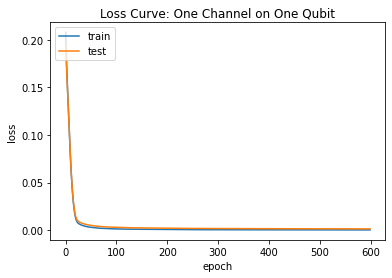

In [107]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0014 - 169ms/epoch - 24ms/step


In [109]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.99615616+3.783498e-12j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [110]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [111]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [112]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [113]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [114]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [115]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [116]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 2s 74ms/step - loss: 0.7230 - val_loss: 0.6751
Epoch 2/600
6/6 [==============================] - 0s 18ms/step - loss: 0.6101 - val_loss: 0.5796
Epoch 3/600
6/6 [==============================] - 0s 18ms/step - loss: 0.5024 - val_loss: 0.4808
Epoch 4/600
6/6 [==============================] - 0s 18ms/step - loss: 0.4029 - val_loss: 0.3852
Epoch 5/600
6/6 [==============================] - 0s 18ms/step - loss: 0.3229 - val_loss: 0.3131
Epoch 6/600
6/6 [==============================] - 0s 17ms/step - loss: 0.2624 - val_loss: 0.2618
Epoch 7/600
6/6 [==============================] - 0s 21ms/step - loss: 0.2158 - val_loss: 0.2215
Epoch 8/600
6/6 [==============================] - 0s 20ms/step - loss: 0.1775 - val_loss: 0.1885
Epoch 9/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1481 - val_loss: 0.1621
Epoch 10/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1248 - val_loss: 0.1407
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0141
Epoch 85/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0045 - val_loss: 0.0140
Epoch 86/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0045 - val_loss: 0.0139
Epoch 87/600
6/6 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0138
Epoch 88/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0137
Epoch 89/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0135
Epoch 90/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 91/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0134
Epoch 92/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 93/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0131
Epoch 94/6

6/6 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 167/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 169/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 170/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 171/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 172/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 173/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 174/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 175/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 176/600


6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 249/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 250/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 251/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 252/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 253/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 254/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 255/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 256/600
6/6 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 257/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 258/600


6/6 [==============================] - 0s 16ms/step - loss: 8.7325e-04 - val_loss: 0.0070
Epoch 329/600
6/6 [==============================] - 0s 16ms/step - loss: 8.8505e-04 - val_loss: 0.0069
Epoch 330/600
6/6 [==============================] - 0s 18ms/step - loss: 8.5807e-04 - val_loss: 0.0069
Epoch 331/600
6/6 [==============================] - 0s 18ms/step - loss: 8.5957e-04 - val_loss: 0.0069
Epoch 332/600
6/6 [==============================] - 0s 15ms/step - loss: 8.5707e-04 - val_loss: 0.0069
Epoch 333/600
6/6 [==============================] - 0s 21ms/step - loss: 8.5005e-04 - val_loss: 0.0069
Epoch 334/600
6/6 [==============================] - 0s 18ms/step - loss: 8.4544e-04 - val_loss: 0.0069
Epoch 335/600
6/6 [==============================] - 0s 16ms/step - loss: 8.3730e-04 - val_loss: 0.0068
Epoch 336/600
6/6 [==============================] - 0s 16ms/step - loss: 8.2587e-04 - val_loss: 0.0069
Epoch 337/600
6/6 [==============================] - 0s 16ms/step - loss: 8.20

Epoch 407/600
6/6 [==============================] - 0s 17ms/step - loss: 6.3612e-04 - val_loss: 0.0064
Epoch 408/600
6/6 [==============================] - 0s 18ms/step - loss: 6.3855e-04 - val_loss: 0.0065
Epoch 409/600
6/6 [==============================] - 0s 16ms/step - loss: 6.4840e-04 - val_loss: 0.0064
Epoch 410/600
6/6 [==============================] - 0s 18ms/step - loss: 6.4056e-04 - val_loss: 0.0064
Epoch 411/600
6/6 [==============================] - 0s 18ms/step - loss: 6.4110e-04 - val_loss: 0.0065
Epoch 412/600
6/6 [==============================] - 0s 16ms/step - loss: 6.3686e-04 - val_loss: 0.0064
Epoch 413/600
6/6 [==============================] - 0s 21ms/step - loss: 6.3793e-04 - val_loss: 0.0064
Epoch 414/600
6/6 [==============================] - 0s 16ms/step - loss: 6.2390e-04 - val_loss: 0.0064
Epoch 415/600
6/6 [==============================] - 0s 16ms/step - loss: 6.1313e-04 - val_loss: 0.0064
Epoch 416/600
6/6 [==============================] - 0s 17ms/ste

Epoch 486/600
6/6 [==============================] - 0s 16ms/step - loss: 5.0771e-04 - val_loss: 0.0062
Epoch 487/600
6/6 [==============================] - 0s 19ms/step - loss: 5.1049e-04 - val_loss: 0.0061
Epoch 488/600
6/6 [==============================] - 0s 20ms/step - loss: 5.1928e-04 - val_loss: 0.0061
Epoch 489/600
6/6 [==============================] - 0s 20ms/step - loss: 4.9942e-04 - val_loss: 0.0061
Epoch 490/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0638e-04 - val_loss: 0.0061
Epoch 491/600
6/6 [==============================] - 0s 17ms/step - loss: 4.8928e-04 - val_loss: 0.0061
Epoch 492/600
6/6 [==============================] - 0s 18ms/step - loss: 4.8397e-04 - val_loss: 0.0061
Epoch 493/600
6/6 [==============================] - 0s 18ms/step - loss: 4.8041e-04 - val_loss: 0.0061
Epoch 494/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8500e-04 - val_loss: 0.0061
Epoch 495/600
6/6 [==============================] - 0s 16ms/ste

Epoch 565/600
6/6 [==============================] - 0s 16ms/step - loss: 4.0271e-04 - val_loss: 0.0059
Epoch 566/600
6/6 [==============================] - 0s 17ms/step - loss: 4.1452e-04 - val_loss: 0.0059
Epoch 567/600
6/6 [==============================] - 0s 16ms/step - loss: 4.0827e-04 - val_loss: 0.0058
Epoch 568/600
6/6 [==============================] - 0s 18ms/step - loss: 4.2579e-04 - val_loss: 0.0058
Epoch 569/600
6/6 [==============================] - 0s 18ms/step - loss: 4.1687e-04 - val_loss: 0.0059
Epoch 570/600
6/6 [==============================] - 0s 19ms/step - loss: 4.0065e-04 - val_loss: 0.0059
Epoch 571/600
6/6 [==============================] - 0s 19ms/step - loss: 4.0758e-04 - val_loss: 0.0058
Epoch 572/600
6/6 [==============================] - 0s 16ms/step - loss: 4.0338e-04 - val_loss: 0.0058
Epoch 573/600
6/6 [==============================] - 0s 18ms/step - loss: 3.9452e-04 - val_loss: 0.0058
Epoch 574/600
6/6 [==============================] - 0s 21ms/ste

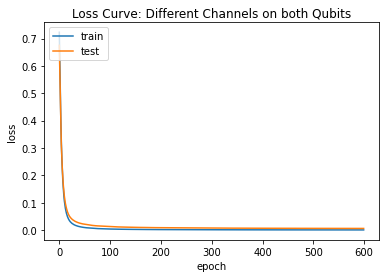

In [117]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0053 - 236ms/epoch - 34ms/step


In [119]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((0.9947194+4.9039953e-11j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [120]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [121]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [122]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [123]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [124]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [125]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [126]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 2s 63ms/step - loss: 0.6908 - val_loss: 0.6074
Epoch 2/600
6/6 [==============================] - 0s 17ms/step - loss: 0.5747 - val_loss: 0.5086
Epoch 3/600
6/6 [==============================] - 0s 21ms/step - loss: 0.4635 - val_loss: 0.4133
Epoch 4/600
6/6 [==============================] - 0s 21ms/step - loss: 0.3654 - val_loss: 0.3350
Epoch 5/600
6/6 [==============================] - 0s 18ms/step - loss: 0.2918 - val_loss: 0.2782
Epoch 6/600
6/6 [==============================] - 0s 18ms/step - loss: 0.2382 - val_loss: 0.2316
Epoch 7/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1947 - val_loss: 0.1927
Epoch 8/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1594 - val_loss: 0.1629
Epoch 9/600
6/6 [==============================] - 0s 22ms/step - loss: 0.1338 - val_loss: 0.1417
Epoch 10/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1144 - val_loss: 0.1253
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0136
Epoch 85/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0135
Epoch 86/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0133
Epoch 87/600
6/6 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0132
Epoch 88/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 89/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0130
Epoch 90/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0129
Epoch 91/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0127
Epoch 92/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0047 - val_loss: 0.0127
Epoch 93/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0124
Epoch 94/6

6/6 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 167/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0081
Epoch 169/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 170/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 171/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 172/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 173/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 174/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 175/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 176/600


6/6 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 249/600
6/6 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 250/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 251/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 252/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 253/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 254/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 255/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 256/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 257/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 258/600


6/6 [==============================] - 0s 16ms/step - loss: 8.4069e-04 - val_loss: 0.0056
Epoch 329/600
6/6 [==============================] - 0s 17ms/step - loss: 8.3463e-04 - val_loss: 0.0056
Epoch 330/600
6/6 [==============================] - 0s 19ms/step - loss: 8.3252e-04 - val_loss: 0.0056
Epoch 331/600
6/6 [==============================] - 0s 19ms/step - loss: 8.3888e-04 - val_loss: 0.0056
Epoch 332/600
6/6 [==============================] - 0s 18ms/step - loss: 8.4023e-04 - val_loss: 0.0056
Epoch 333/600
6/6 [==============================] - 0s 18ms/step - loss: 8.4261e-04 - val_loss: 0.0056
Epoch 334/600
6/6 [==============================] - 0s 20ms/step - loss: 8.3117e-04 - val_loss: 0.0056
Epoch 335/600
6/6 [==============================] - 0s 18ms/step - loss: 8.1947e-04 - val_loss: 0.0056
Epoch 336/600
6/6 [==============================] - 0s 16ms/step - loss: 7.9967e-04 - val_loss: 0.0055
Epoch 337/600
6/6 [==============================] - 0s 21ms/step - loss: 8.09

Epoch 407/600
6/6 [==============================] - 0s 17ms/step - loss: 6.3352e-04 - val_loss: 0.0052
Epoch 408/600
6/6 [==============================] - 0s 16ms/step - loss: 6.3361e-04 - val_loss: 0.0052
Epoch 409/600
6/6 [==============================] - 0s 18ms/step - loss: 6.2570e-04 - val_loss: 0.0052
Epoch 410/600
6/6 [==============================] - 0s 16ms/step - loss: 6.2028e-04 - val_loss: 0.0053
Epoch 411/600
6/6 [==============================] - 0s 18ms/step - loss: 6.3110e-04 - val_loss: 0.0052
Epoch 412/600
6/6 [==============================] - 0s 16ms/step - loss: 6.1697e-04 - val_loss: 0.0052
Epoch 413/600
6/6 [==============================] - 0s 16ms/step - loss: 6.1223e-04 - val_loss: 0.0052
Epoch 414/600
6/6 [==============================] - 0s 18ms/step - loss: 6.2239e-04 - val_loss: 0.0052
Epoch 415/600
6/6 [==============================] - 0s 18ms/step - loss: 6.2178e-04 - val_loss: 0.0052
Epoch 416/600
6/6 [==============================] - 0s 16ms/ste

Epoch 486/600
6/6 [==============================] - 0s 18ms/step - loss: 4.8846e-04 - val_loss: 0.0049
Epoch 487/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8816e-04 - val_loss: 0.0050
Epoch 488/600
6/6 [==============================] - 0s 16ms/step - loss: 4.9093e-04 - val_loss: 0.0050
Epoch 489/600
6/6 [==============================] - 0s 19ms/step - loss: 4.7877e-04 - val_loss: 0.0050
Epoch 490/600
6/6 [==============================] - 0s 16ms/step - loss: 4.7628e-04 - val_loss: 0.0049
Epoch 491/600
6/6 [==============================] - 0s 16ms/step - loss: 4.7634e-04 - val_loss: 0.0049
Epoch 492/600
6/6 [==============================] - 0s 16ms/step - loss: 4.7569e-04 - val_loss: 0.0050
Epoch 493/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8673e-04 - val_loss: 0.0050
Epoch 494/600
6/6 [==============================] - 0s 18ms/step - loss: 4.9427e-04 - val_loss: 0.0049
Epoch 495/600
6/6 [==============================] - 0s 18ms/ste

Epoch 565/600
6/6 [==============================] - 0s 18ms/step - loss: 4.0331e-04 - val_loss: 0.0048
Epoch 566/600
6/6 [==============================] - 0s 17ms/step - loss: 4.0821e-04 - val_loss: 0.0048
Epoch 567/600
6/6 [==============================] - 0s 16ms/step - loss: 4.0535e-04 - val_loss: 0.0048
Epoch 568/600
6/6 [==============================] - 0s 18ms/step - loss: 4.0304e-04 - val_loss: 0.0048
Epoch 569/600
6/6 [==============================] - 0s 19ms/step - loss: 3.9916e-04 - val_loss: 0.0048
Epoch 570/600
6/6 [==============================] - 0s 18ms/step - loss: 3.8271e-04 - val_loss: 0.0048
Epoch 571/600
6/6 [==============================] - 0s 18ms/step - loss: 3.8623e-04 - val_loss: 0.0048
Epoch 572/600
6/6 [==============================] - 0s 18ms/step - loss: 3.8055e-04 - val_loss: 0.0048
Epoch 573/600
6/6 [==============================] - 0s 20ms/step - loss: 3.9092e-04 - val_loss: 0.0048
Epoch 574/600
6/6 [==============================] - 0s 16ms/ste

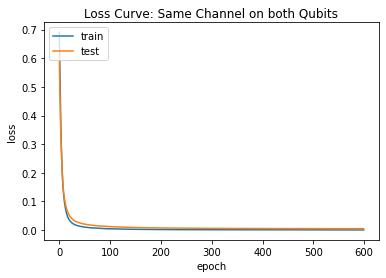

In [127]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [128]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0050 - 210ms/epoch - 30ms/step


In [129]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((0.99497366+4.0163286e-11j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [130]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [131]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [132]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [133]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [134]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [135]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [136]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 2s 122ms/step - loss: 0.6533 - val_loss: 0.5739
Epoch 2/600
6/6 [==============================] - 0s 18ms/step - loss: 0.5266 - val_loss: 0.4658
Epoch 3/600
6/6 [==============================] - 0s 19ms/step - loss: 0.4130 - val_loss: 0.3705
Epoch 4/600
6/6 [==============================] - 0s 18ms/step - loss: 0.3196 - val_loss: 0.3009
Epoch 5/600
6/6 [==============================] - 0s 16ms/step - loss: 0.2526 - val_loss: 0.2498
Epoch 6/600
6/6 [==============================] - 0s 17ms/step - loss: 0.2071 - val_loss: 0.2102
Epoch 7/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1712 - val_loss: 0.1790
Epoch 8/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1441 - val_loss: 0.1541
Epoch 9/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1223 - val_loss: 0.1344
Epoch 10/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1054 - val_loss: 0.1190
Epoch 11/600
6/6 [

Epoch 84/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 0.0150
Epoch 85/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 86/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0148
Epoch 87/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0146
Epoch 88/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0146
Epoch 89/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0145
Epoch 90/600
6/6 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0144
Epoch 91/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0142
Epoch 92/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0141
Epoch 93/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0140
Epoch 94/6

6/6 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 167/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 169/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 170/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 171/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 172/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 173/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 174/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 175/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 176/600


6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0090
Epoch 249/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 250/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 251/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 252/600
6/6 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 253/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 254/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 255/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 256/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 257/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0089
Epoch 258/600


6/6 [==============================] - 0s 18ms/step - loss: 8.8539e-04 - val_loss: 0.0083
Epoch 330/600
6/6 [==============================] - 0s 18ms/step - loss: 8.8675e-04 - val_loss: 0.0083
Epoch 331/600
6/6 [==============================] - 0s 18ms/step - loss: 8.8249e-04 - val_loss: 0.0083
Epoch 332/600
6/6 [==============================] - 0s 14ms/step - loss: 8.7272e-04 - val_loss: 0.0082
Epoch 333/600
6/6 [==============================] - 0s 18ms/step - loss: 8.7071e-04 - val_loss: 0.0083
Epoch 334/600
6/6 [==============================] - 0s 16ms/step - loss: 8.7409e-04 - val_loss: 0.0082
Epoch 335/600
6/6 [==============================] - 0s 18ms/step - loss: 8.6241e-04 - val_loss: 0.0083
Epoch 336/600
6/6 [==============================] - 0s 17ms/step - loss: 8.6514e-04 - val_loss: 0.0082
Epoch 337/600
6/6 [==============================] - 0s 21ms/step - loss: 8.5819e-04 - val_loss: 0.0083
Epoch 338/600
6/6 [==============================] - 0s 16ms/step - loss: 8.63

Epoch 408/600
6/6 [==============================] - 0s 21ms/step - loss: 6.7090e-04 - val_loss: 0.0079
Epoch 409/600
6/6 [==============================] - 0s 19ms/step - loss: 6.7171e-04 - val_loss: 0.0078
Epoch 410/600
6/6 [==============================] - 0s 17ms/step - loss: 6.6058e-04 - val_loss: 0.0079
Epoch 411/600
6/6 [==============================] - 0s 19ms/step - loss: 6.5487e-04 - val_loss: 0.0078
Epoch 412/600
6/6 [==============================] - 0s 18ms/step - loss: 6.4813e-04 - val_loss: 0.0079
Epoch 413/600
6/6 [==============================] - 0s 19ms/step - loss: 6.4139e-04 - val_loss: 0.0078
Epoch 414/600
6/6 [==============================] - 0s 18ms/step - loss: 6.3350e-04 - val_loss: 0.0078
Epoch 415/600
6/6 [==============================] - 0s 18ms/step - loss: 6.3373e-04 - val_loss: 0.0078
Epoch 416/600
6/6 [==============================] - 0s 21ms/step - loss: 6.4584e-04 - val_loss: 0.0078
Epoch 417/600
6/6 [==============================] - 0s 19ms/ste

Epoch 487/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0918e-04 - val_loss: 0.0076
Epoch 488/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0052e-04 - val_loss: 0.0077
Epoch 489/600
6/6 [==============================] - 0s 18ms/step - loss: 5.0295e-04 - val_loss: 0.0076
Epoch 490/600
6/6 [==============================] - 0s 19ms/step - loss: 5.0420e-04 - val_loss: 0.0076
Epoch 491/600
6/6 [==============================] - 0s 17ms/step - loss: 4.9706e-04 - val_loss: 0.0077
Epoch 492/600
6/6 [==============================] - 0s 18ms/step - loss: 4.9253e-04 - val_loss: 0.0076
Epoch 493/600
6/6 [==============================] - 0s 18ms/step - loss: 4.8511e-04 - val_loss: 0.0076
Epoch 494/600
6/6 [==============================] - 0s 16ms/step - loss: 4.8575e-04 - val_loss: 0.0076
Epoch 495/600
6/6 [==============================] - 0s 18ms/step - loss: 4.8018e-04 - val_loss: 0.0076
Epoch 496/600
6/6 [==============================] - 0s 19ms/ste

Epoch 566/600
6/6 [==============================] - 0s 18ms/step - loss: 3.9884e-04 - val_loss: 0.0075
Epoch 567/600
6/6 [==============================] - 0s 19ms/step - loss: 3.9536e-04 - val_loss: 0.0075
Epoch 568/600
6/6 [==============================] - 0s 18ms/step - loss: 3.9732e-04 - val_loss: 0.0075
Epoch 569/600
6/6 [==============================] - 0s 16ms/step - loss: 3.8591e-04 - val_loss: 0.0075
Epoch 570/600
6/6 [==============================] - 0s 18ms/step - loss: 3.9290e-04 - val_loss: 0.0075
Epoch 571/600
6/6 [==============================] - 0s 16ms/step - loss: 3.9616e-04 - val_loss: 0.0075
Epoch 572/600
6/6 [==============================] - 0s 14ms/step - loss: 3.8837e-04 - val_loss: 0.0075
Epoch 573/600
6/6 [==============================] - 0s 16ms/step - loss: 4.0556e-04 - val_loss: 0.0075
Epoch 574/600
6/6 [==============================] - 0s 16ms/step - loss: 3.9626e-04 - val_loss: 0.0075
Epoch 575/600
6/6 [==============================] - 0s 17ms/ste

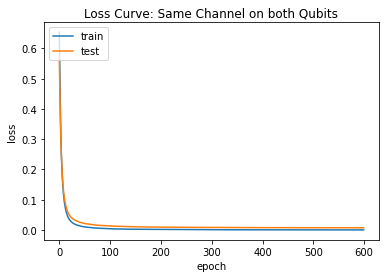

In [137]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [138]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0068 - 217ms/epoch - 31ms/step


In [139]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((0.99324065+3.6670826e-11j), shape=(), dtype=complex64)
